# Building a mask for Arabian sea

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

# use intake-esm to load the Pangeo CMIP6 cloud collection
import intake

# use regionmask to mask any desired region (we don't use it in this notebook currently)
import regionmask

from cmip6_preprocessing.preprocessing import combined_preprocessing
from cmip6_preprocessing.postprocessing import merge_variables, concat_members, concat_experiments
from cmip6_preprocessing.regionmask import merged_mask

import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

In [2]:
## Taking input from Pangeo cloud

col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

## Getting data

In [3]:
## Narrowing down on experiments which are relevant for our use

#Taking historical instead of ssp126 because all ensembles of ssp126 either contain no3os or tos, but not both.
elist1 = col.df[col.df.experiment_id == 'historical'].source_id.unique() 
elist2 = col.df[col.df.experiment_id == 'ssp585'].source_id.unique()
elist = set(elist1).intersection(elist2)

vlist1 = col.df[col.df.variable_id == 'no3os'].source_id.unique()
vlist2 = col.df[col.df.variable_id == 'tos'].source_id.unique()
vlist = set(vlist1).intersection(vlist2)

mlist = col.df[col.df.member_id == 'r1i1p1f1'].source_id.unique()

model_list = set(elist).intersection(vlist).intersection(mlist)

In [4]:
model_list

{'ACCESS-ESM1-5',
 'CESM2',
 'CESM2-WACCM',
 'CanESM5',
 'GFDL-ESM4',
 'GISS-E2-1-G',
 'IPSL-CM6A-LR',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'NorESM2-LM',
 'NorESM2-MM'}

This is the model list which has 'r1i1p1f1' as the name of an ensemble member, variables 'no3os' and 'tos' for our use and the required experiments: 'historical' and 'ssp585'. For this exercise, we only take one model and one ensemble (due to computational resources constraints), and look at the differences between historical run and RCP8.5 with respect to nitrate emissions.

In [5]:
variable_list = ['tos', 'no3os'] # SST & surface dissolved nitrate concentration

cat = col.search(
    variable_id = variable_list,
    source_id = ['ACCESS-ESM1-5'],#,'IPSL-CM6A-LR'],
    #source_id = ['ACCESS-ESM1-5', 'NorESM2-LM'],
    grid_label = 'gn',
    table_id = 'Omon',
    experiment_id = ['historical', 'ssp585'],
    member_id = ['r1i1p1f1']#,'r2i1p1f1'] #Take only one ensemble member otherwise kernel dies
)

# load all datasets into a python dictionary
ddict = cat.to_dataset_dict(
    zarr_kwargs = {'consolidated':True, 'use_cftime':True}, # recommended for faster reading and better time handling
    storage_options = {'token': 'anon'}, # needed to access the public CMIP6 data on google
    aggregate = False,
    preprocess = combined_preprocessing  # needed to remove longitude and latitude from list of data variables 
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


## Preprocessing

In [6]:
# Merging dictionary having same experiment

ddict_combine_all = merge_variables(ddict)

In [7]:
# Taking only those datasets which contain all the required variables
corrected_dict = {}
for key in ddict_combine_all:
    var_list_model = list(ddict_combine_all[key].data_vars)
    count = 0         
    
    # This loop makes sure that we only take those datasets which have both nitrate and SST in their outputs.
    for word in var_list_model:
        if ((word == "tos") | (word == "no3os")):
            count = count + 1
    
    # Currently, the variable list is 2.
    if(count == len(variable_list)):
        corrected_dict.update({key: ddict_combine_all[key].values()})

## Masking the Arabian sea:

Two ways of doing this:
1. By using regionmask package 
2. By applying manual filtering for Arabian sea

We begin with applying the regionmask package

In [110]:
# load ocean basin data
basins = regionmask.defined_regions.natural_earth.ocean_basins_50

basins[15]

## These are incorrect. 0 is for North Atlantic. Couldn't figure out what is the index number for Bay of Bengal. Maybe someone can help me??

Region: Arabian Sea (Arabian Sea / 15)
center: [63.8675008  13.33111854]

In [9]:
from cmip6_preprocessing.postprocessing import merge_variables, concat_members, concat_experiments

# Merging the different variables and ensemble members into one dataset for spatial maps.
ddict_combined = concat_members(merge_variables(ddict))

/srv/conda/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:113: UserWarning: Match attributes ['variable_id'] not found in any of the datasets.         This can happen when several combination functions are used.
  warnings.warn(


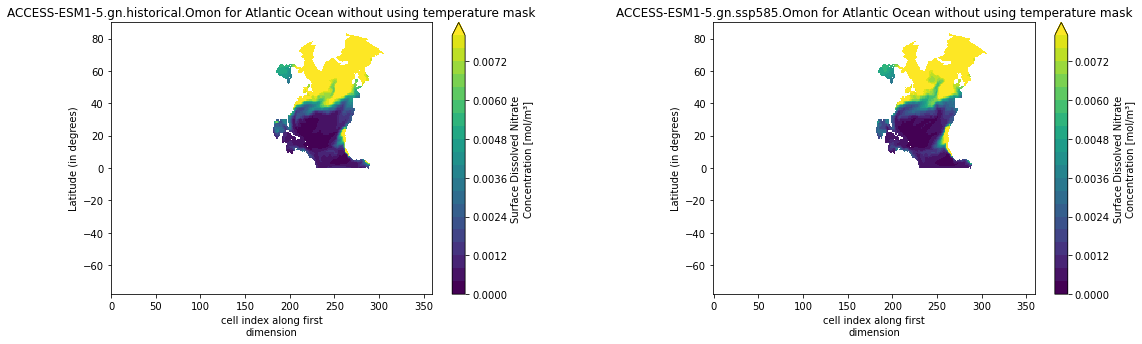

In [82]:
fig, axarr = plt.subplots(ncols = 2, nrows = 1, figsize = (18,5))
for ax, (name, ds) in zip(axarr.flat, ddict_combined.items()):
    # show just the first time step. We can select any time step by changing the line below.
    ds = ds.isel(time = 0)
    da = ds.no3os
    
    mask = merged_mask(basins, da)
    
    #Only needed when we have more than one ensemble members. Currently, we only have r1i1p1f1
    # average all members
    #if 'member_id' in ds.dims:
    #    da = da.mean('member_id')
    
    da_masked = da.where(mask == 0) # switch the number here for a different basin.
    
    #da_masked.sel(lon = slice(-90, 10)).sel(lat = slice(10, 65)).plot(ax = ax, levels = np.linspace(0, 8e-3, 21))
    da_masked.plot(ax = ax, y = 'lat', levels = np.linspace(0, 8e-3, 21))
    #ax.set_xlabel('Longitude (in degrees)')
    ax.set_ylabel('Latitude (in degrees)')
    ax.set_title(name + ' for Atlantic Ocean without using temperature mask')
fig.subplots_adjust(hspace = 0.5, wspace = 0.5)

In the figure above, we didn't put any constraints on the emission of nitrate with respect to the SST. But now, we put constraints, and observe that the spatial map has changed quite significantly. We don't see emissions from high latitudes, because their SSTs are below 25 degree Celsius. So, intuitively, the graph does make sense.

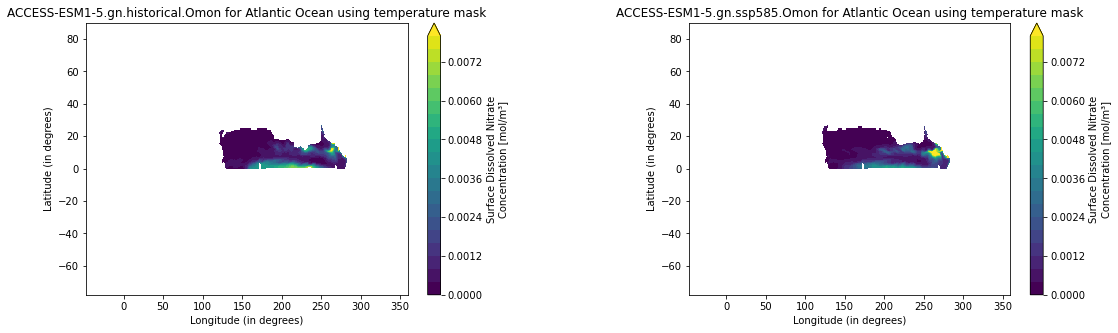

In [11]:
fig, axarr = plt.subplots(ncols = 2, nrows = 1, figsize = (18,5))
for ax, (name, ds) in zip(axarr.flat, ddict_combined.items()):
    # show just the first time step
    ds = ds.isel(time = 0)
    da = ds.no3os.where(ds.tos>=25)
    
    mask = merged_mask(basins, da)
    
    #Only needed when we have more than one ensemble members
    # average all members
    #if 'member_id' in ds.dims:
    #    da = da.mean('member_id')
    
    da_masked = da.where(mask == 2) # switch the number here for a different basin.
    
    da_masked.plot(ax = ax, x = 'lon', y = 'lat', levels = np.linspace(0, 8e-3, 21))
    ax.set_xlabel('Longitude (in degrees)')
    ax.set_ylabel('Latitude (in degrees)')
    ax.set_title(name + ' for Atlantic Ocean using temperature mask')
fig.subplots_adjust(hspace = 0.5, wspace = 0.5)

Next up, we try to plot nitrate emissions for the Arabian sea. Unfortunately, I couldn't find the relevant ID for basins; the closest I found is the coast of Thailand and Sumatra.

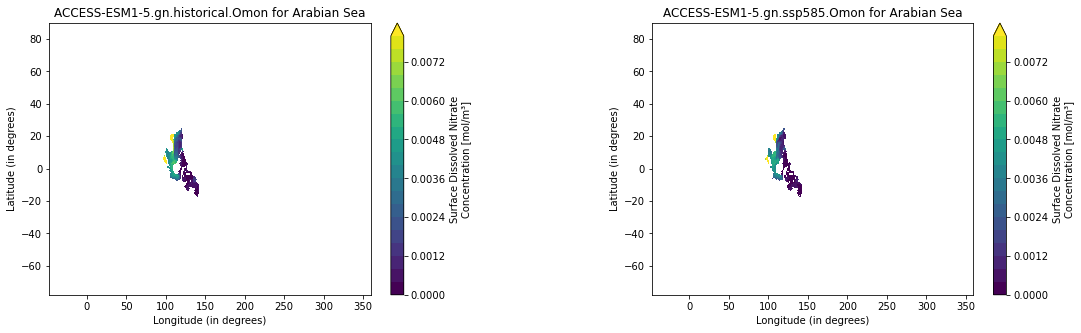

In [103]:
# Need to find the right ID for basins mask. Right now, I think it's pointing towards the coast of Thailand and Sumatra, 

fig, axarr = plt.subplots(ncols = 2, nrows = 1, figsize = (18,5))
for ax, (name, ds) in zip(axarr.flat, ddict_combined.items()):
    
    da = ds.isel(time = 0).no3os
    mask = merged_mask(basins, da)
    
    #Only needed when we have more than one ensemble members
    # average all members
    #if 'member_id' in ds.dims:
    #    da = da.mean('member_id')
    
    da_masked = da.where(mask == 4) # switch the number here for a different basin.
    
    da_masked.plot(ax = ax, x = 'lon', y = 'lat', levels = np.linspace(0, 8e-3, 21))
    ax.set_xlabel('Longitude (in degrees)')
    ax.set_ylabel('Latitude (in degrees)')
    ax.set_title(name + ' for Arabian Sea')
fig.subplots_adjust(hspace = 0.5, wspace = 0.5)

As we can see in the above figure, everything is Nan. I also checked by outputting data, and everything is Nan. Maybe there is some issue with basins package, because I am unable to use mask == 15 and output values for Arabian sea. 

Moving on to the second way of masking data, i.e., by creating a mask for Arabian sea.

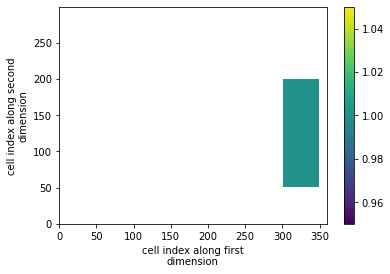

In [52]:
import xarray as xr
latitude = ds.lat
longitude = ds.lon

x_min, x_max = 300, 350
y_min, y_max = 50, 200

# Creating a data array of ones.
data = np.ones((latitude.values.shape))
mask = xr.DataArray(data, coords = [ds.y, ds.x], dims = ["y", "x"])

# Masking for arabian sea. Hardcoding the x and y range, but can be changed to any ocean.
mask_AS = mask.where((mask.x < x_max) & (mask.x > x_min) & (mask.y < y_max) & (mask.y > y_min))
mask_AS.plot()

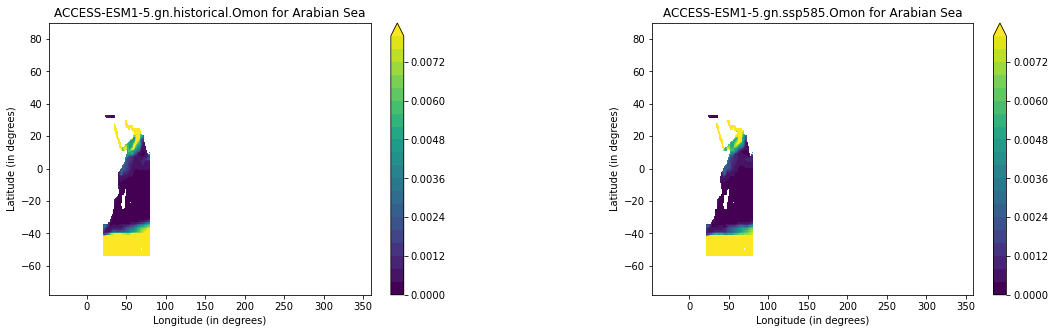

In [57]:
# Hardcoding for Arabian sea, but can be changed to any ocean.
x_min, x_max = 300, 360
y_min, y_max = 50, 200
data = np.ones((latitude.values.shape))

fig, axarr = plt.subplots(ncols = 2, nrows = 1, figsize = (18,5))
for ax, (name, ds) in zip(axarr.flat, ddict_combined.items()):
    
    da = ds.isel(time = 0).no3os
    
    latitude = ds.lat
    longitude = ds.lon
    
    x_dir = latitude.sel(x = slice(x_min, x_max)).sel(y = slice(y_min, y_max))
    y_dir = latitude.sel(x = slice(x_min, x_max)).sel(y = slice(y_min, y_max))
    
    mask = xr.DataArray(data, coords = [ds.y, ds.x], dims = ['y', 'x'])
    mask_AS = mask.where((mask.x < x_max) & (mask.x > x_min) & (mask.y < y_max) & (mask.y > y_min))
    #Only needed when we have more than one ensemble members
    # average all members
    #if 'member_id' in ds.dims:
    #    da = da.mean('member_id')
    
    da_masked = da * mask_AS # switch the number here for a different basin.
    
    #mask_AS.plot(ax = ax)
    da_masked.plot(ax = ax, x = 'lon', y = 'lat', levels = np.linspace(0, 8e-3, 21))
    ax.set_xlabel('Longitude (in degrees)')
    ax.set_ylabel('Latitude (in degrees)')
    ax.set_title(name + ' for Arabian Sea')
fig.subplots_adjust(hspace = 0.5, wspace = 0.5)

This way, we created a mask for the Arabian sea. To check whether our results are correct, we perform a similar analysis for the North Atlantic ocean and compare the results from previous section.

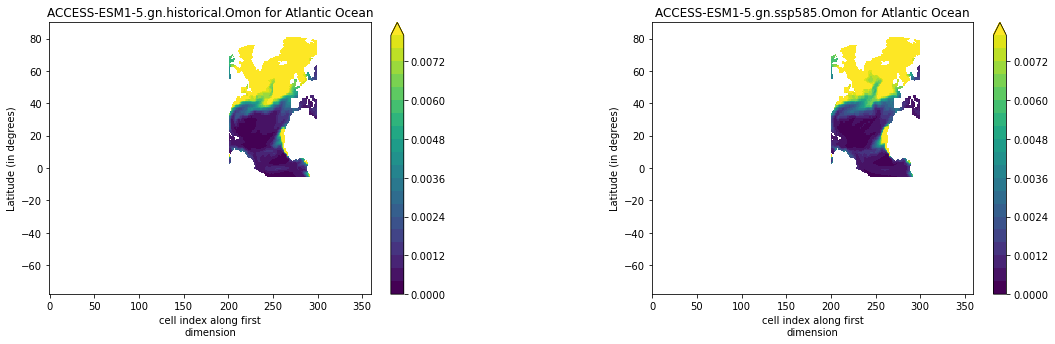

In [84]:
# Hardcoding for North Atlanic Ocean, but can be changed to any ocean.
x_min, x_max = 200, 300
y_min, y_max = 120, 280

fig, axarr = plt.subplots(ncols = 2, nrows = 1, figsize = (18,5))
for ax, (name, ds) in zip(axarr.flat, ddict_combined.items()):
    
    da = ds.isel(time = 0).no3os
    
    latitude = ds.lat
    
    data = np.ones((latitude.values.shape))
    
    mask = xr.DataArray(data, coords = [ds.y, ds.x], dims = ['y', 'x'])
    mask_NA = mask.where((mask.x < x_max) & (mask.x > x_min) & (mask.y < y_max) & (mask.y > y_min))
    #Only needed when we have more than one ensemble members
    # average all members
    #if 'member_id' in ds.dims:
    #    da = da.mean('member_id')
    
    da_masked = da * mask_NA # switch the number here for a different basin.
    
    da_masked.plot(ax = ax, y = 'lat', levels = np.linspace(0, 8e-3, 21))
    #ax.set_xlabel('Longitude (in degrees)')
    ax.set_ylabel('Latitude (in degrees)')
    ax.set_title(name + ' for Atlantic Ocean')
fig.subplots_adjust(hspace = 0.5, wspace = 0.5)

## Regridding data

xESMF package is not present in the base environment. Check if there is(are) any other package(s) that can be used to achieve this task.

## Averaging spatial data to form time series

In [117]:
# load the metric data
cat_m = col.search(
    variable_id=['areacello'],# this is the surface area
    source_id = ['ACCESS-ESM1-5'],
)

# load all datasets into a python dictionary (like before)
ddict_metrics = cat_m.to_dataset_dict(
    zarr_kwargs={'consolidated':True, 'use_cftime':True}, # recommended for faster reading and better time handling
    storage_options={'token': 'anon'}, # needed to access the public CMIP6 data on google
    aggregate=False,
    preprocess=combined_preprocessing, # ! Important to apply the preprocessing to the metrics as well!
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [118]:
from cmip6_preprocessing.postprocessing import match_metrics
# at the moment the metrics have to be matched before comining datasets
ddict_w_metrics = match_metrics(ddict, ddict_metrics, ['areacello'])

In [122]:
# Unlike Julius's notebook, we do not concatenate along the two types of runs: historical and RCP8.5, so we can compare between them.
ddict_combined_w_metrics = concat_members(merge_variables(ddict_w_metrics))

Text(0.5, 1.0, 'ACCESS-ESM1-5.gn: RCP8.5 run')

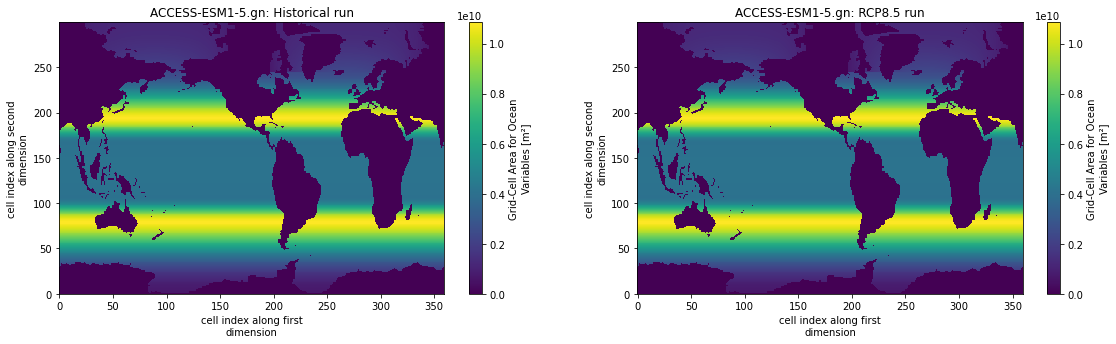

In [130]:
fig, axes = plt.subplots(ncols = 2, figsize = (19, 5))

ddict_combined_w_metrics['ACCESS-ESM1-5.gn.historical.Omon'].areacello.plot(ax = axes[0])
axes[0].set_title('ACCESS-ESM1-5.gn: Historical run')
ddict_combined_w_metrics['ACCESS-ESM1-5.gn.ssp585.Omon'].areacello.plot(ax = axes[1])
axes[1].set_title('ACCESS-ESM1-5.gn: RCP8.5 run')

[########################################] | 100% Completed |  6.5s
[########################################] | 100% Completed |  6.1s
[########################################] | 100% Completed |  3.3s
[########################################] | 100% Completed |  4.8s


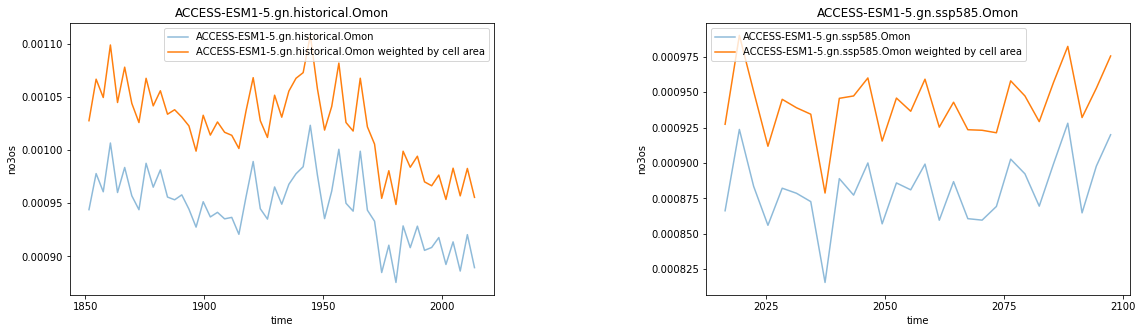

In [140]:
time_window = 36
fig, axarr = plt.subplots(ncols = 2, nrows = 1, figsize = (19,5))
for ax, (name, ds) in zip(axarr.flat, ddict_combined_w_metrics.items()):    
    # mask out the SSH where the SST is above 20 deg
    da = ds.no3os.where(ds.tos>=25)
        
    # mask out the indian ocean
    mask = merged_mask(basins, da)
    
    da_masked = da.where(mask == 5)
    
    # wrong version
    da_timeseries = da_masked.mean(['x', 'y'])
    
    # all we need is .weighted (also make sure that nans are filled with 0s using .fillna())
    da_timeseries_weighted = da_masked.weighted(da_masked.areacello.fillna(0)).mean(['x', 'y'])
    
    # this is now a heavy computation, using the full dataset! So it might take a bit...
    with ProgressBar():
        #Load the timeseries into memory and average in 3 year intervals to supress short term variability
        da_timeseries = da_timeseries.load().coarsen(time=time_window, boundary='trim').mean()
        da_timeseries_weighted = da_timeseries_weighted.load().coarsen(time=time_window, boundary='trim').mean()
    
    
    da_timeseries.plot(ax=ax, hue='member_id', alpha=0.5, color='C0', label = name)
    da_timeseries_weighted.plot(ax=ax, hue='member_id', color='C1', label = name + ' weighted by cell area')
    ax.legend()
    ax.set_title(name)
fig.subplots_adjust(hspace=0.5, wspace=0.5)

## Model de-drifting

Will think about it!

Final goal is to be able to compare the RCP2.6 vs RCP8.5 emissions, but for that, correct datasets need to be found.